#Final Skills Test

###Background:
Bengio's students wrote a paper discussing the use of neural nets for predicting sunspot activity.  Here's a link to their paper: 
http://bengio.abracadoudou.com/cv/publications/pdf/fessant_1995_ag.pdf

The paper discusses several neural net approaches that they take to the problem.  One they call multi layer perceptron (MLP).  That corresponds to what we have been calling a fully connected feed forward network.  They also train an Elman net which is the first RNN that we looked at in class.  

They are predicting sunspot activity, which is important to communications traffic because it affects the ionospheric conditions in a way that alters the transmission of radio waves on earth.  Reflection of some radio waves off of the ionosphere makes it possible to communicate over the horizon and sunspot activity can alter the frequencies that the ionosphere reflects.  (Notice that one of the students was at CNET - France Telecom's lab for communications studies.)

You can see from the plot in the paper (or by plotting the attached files) that sunspots are roughly periodic with a period around 11 years.  The task here is to build your own neural nets to accomplish this prediction and to compare your results to the results that Bengio and his students got in their paper.  

You'll see in the paper some discussion of "embedding dimension".  Consider how you'd use a fully connected feed forward network to do time series prediction.  The usual method is to give the FC a segment of the time series that includes the present value and several values into the past and then train the FC network against labels that are the future value.  The width of the input layer (the number of past values given the network) is called the "embedding dimension".  

The authors also used an Elman Net for the prediction task and as you know from your own experimentation with RNN, you can train an RNN the current time series point alone or on the current and past values - so it's relevant to think about optimum embedding dimension for RNN as well as for FC network.  

###Problem Statement:  
Build two networks to predict sunspot activity 6 months ahead.  One should be a fully connected feed forward network and the other should be an LSTM.  For each try a few different embedding dimensions.  Compare your best performing FC and your best performing LSTM with the results that the authors got in their paper.  

There are two data sets included in this folder.  Both come from the Royal Solar Observatory in Belgium.  One is daily sunspot data dating from the early 19th century.  The other is monthly data dating from the late 18th century.  You may use either data set (or both).  You'll get the most direct comparison using the monthly data.  Submit python notebook with working code (including output) and the writeup of your comparison.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import cPickle as pickle
from math import sqrt
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from itertools import izip
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import theano
%matplotlib inline

##Flow

    Import Data
    Formate Data
    Run LSTM
    Score LSTM Performance
    Run 4 Layer FC Network
    Score Network Performance

###Error Metric

In [2]:
def get_Strong_Error_Percentage(error_list):
    miss = 0
    for dist in error_list:
        if dist > 30.0:
            miss += 1
    return miss/ float(len(error_list))

###Import Data
    Data used is monthly mean of subspots

In [3]:
def formatter(dataList, histLength=40, predLag=6, trainFrac=0.80):
    # Embedding Dimensions, d = 40
    # define pointer that starts at histLength and runs to length - predLag
    attr = []
    y = []
    
    for iPoint in range(histLength, len(dataList) - predLag):
        # flatten history before iPoint and calculate change in closing price between iPoint and iPoint + predLag
        attrLine = []
        
        for i in range(iPoint-histLength, iPoint):
            # flattens histLength many rows into a single row
            attrLine += dataList[i]
            
        # attrLine = [temp + dataList[i] for i in range(iPoint-histLength, iPoint)]
        attr.append(attrLine)
        currClse = dataList[iPoint][0]          # only get sunspots
        futClse = dataList[iPoint + predLag][0] # only get sunspots
        yVal = futClse - currClse
        y.append(yVal)  #difference in closing prices
        
    #calculate index for start of training set
    #trainStart = int(trainFrac * len(attr))
    #xTr = attr[:trainStart]; xTe = attr[trainStart:]; yTr = y[:trainStart]; yTe = y[trainStart:]
    #xTr = np.array(attr)
    #yTr = np.array(y)
    #attr = MaxAbsScaler().fit_transform(attr)
    return  attr, y    #take raw pricing data, return numpy array of attributes and labels

In [4]:
df = pd.read_csv("./SN_m_tot_V2.0.csv",sep = ";", header = None)

    Column 1-2: Gregorian calendar date
    - Year
    - Month
    Column 3: Date in fraction of year for the middle of the corresponding month
    Column 4: Monthly mean total sunspot number.
    Column 5: Monthly mean standard deviation of the input sunspot numbers from individual stations.
    Column 6: Number of observations used to compute the monthly mean total sunspot number.
    Column 7: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the monthly value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)

In [5]:
# interested in time [index 2] and mean sunspots [index 3]
df.values.tolist()[0]

[1749.0, 1.0, 1749.0420000000001, 96.7, -1.0, -1.0, 1.0]

In [6]:
sunspots = [df.values.tolist()[row][3] for row in xrange(0,len(df.values.tolist()))]   

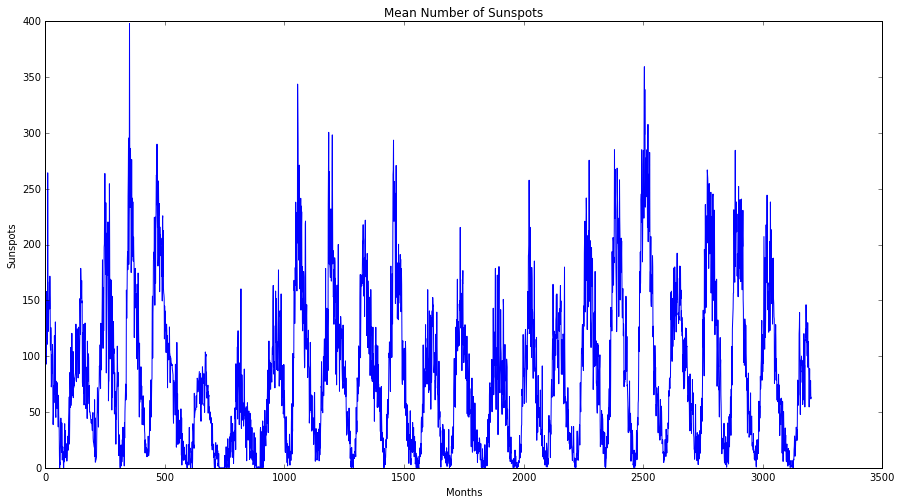

In [7]:
plt.figure(figsize = (15,8));
plt.title("Mean Number of Sunspots");
plt.ylabel("Sunspots");
plt.xlabel("Months")
plt.plot(sunspots);

###Format

In [8]:
x_past_datas_sunspots, y_true_future_sunspot = formatter(df.values[:,3:4].tolist())

In [9]:
# X cols: t1 | R1 | t2 | R2 | t3 | R3 | ... | tn | Rn
print np.array(x_past_datas_sunspots).shape
# Y col:  R
print np.array(y_true_future_sunspot).shape

(3157, 40)
(3157,)


In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(x_past_datas_sunspots,
                                                y_true_future_sunspot,
                                                test_size = 0.15,
                                               random_state = 1)

###Normalize

Bengio paper states that the data's mean should be centered aroud zero and scaled between [-1,1]

In [11]:
# StandardScaler centers data around 0
x_ss = StandardScaler().fit_transform(xTrain)
# MaxAbsScaler scales data between [-1,1]
x_mas = MaxAbsScaler().fit_transform(x_ss)

In [12]:
xtest_ss = StandardScaler().fit_transform(xTest)
xtest_mas = MaxAbsScaler().fit_transform(xtest_ss)

In [13]:
print"MaxAbsScaler"
print  np.max(xtest_mas)
print np.min(xtest_mas)

MaxAbsScaler
1.0
-0.423525344255


In [14]:
Xtrain = np.array(x_mas, dtype = theano.config.floatX)
ytrain = np.array(yTrain, dtype = theano.config.floatX)
Xtest = np.array(xtest_mas, dtype = theano.config.floatX)
Ytest = np.array(yTest, dtype = theano.config.floatX)

##LSTM Network

In [15]:
class RNN(object):

    def __init__(self, nin, n_hidden, nout):
        rng = np.random.RandomState(1234)
        # cell input
        W_ug = np.asarray(rng.normal(size=(nin, n_hidden), scale= .01, loc = 0.0), dtype = theano.config.floatX)
        W_hg = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = 0.0), dtype = theano.config.floatX)
        b_g = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # input gate equation
        W_ui = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hi = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_i = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # forget gate equations
        W_uf = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_hf = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_f = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # cell output gate equations
        W_uo = np.asarray(rng.normal(size=(nin, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        W_ho = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_o = np.zeros((n_hidden,), dtype=theano.config.floatX)
        # output layer
        W_hy = np.asarray(rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
        b_hy = np.zeros((nout,), dtype=theano.config.floatX)

        # cell input
        W_ug = theano.shared(W_ug, 'W_ug')
        W_hg = theano.shared(W_hg, 'W_hg')
        b_g = theano.shared(b_g, 'b_g')
        # input gate equation
        W_ui = theano.shared(W_ui, 'W_ui')
        W_hi = theano.shared(W_hi, 'W_hi')
        b_i = theano.shared(b_i, 'b_i')
        # forget gate equations
        W_uf = theano.shared(W_uf, 'W_uf')
        W_hf = theano.shared(W_hf, 'W_hf')
        b_f = theano.shared(b_f, 'b_f')
        # cell output gate equations
        W_uo = theano.shared(W_uo, 'W_uo')
        W_ho = theano.shared(W_ho, 'W_ho')
        b_o = theano.shared(b_o, 'b_o')
        # output layer
        W_hy = theano.shared(W_hy, 'W_hy')
        b_hy = theano.shared(b_hy, 'b_hy')

        self.activ1 = T.nnet.sigmoid
        self.activ2 = T.tanh
        
        lr = T.scalar()
        u = T.matrix()
        t = T.scalar()


        h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))
        s0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))


        #theano.printing.debugprint([h0_tm1, u, W_hh, W_uh, W_hy, b_hh, b_hy], print_type=True)
        [h, s], _ = theano.scan(self.recurrent_fn, sequences = u,
                           outputs_info = [h0_tm1, s0_tm1],
                           non_sequences = [W_ug, W_hg, b_g, W_ui, W_hi,
                                            b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy])

        y = T.dot(h[-1], W_hy) + b_hy
        cost = ((t - y)**2).mean(axis=0).sum()

        gW_ug, gW_hg, gb_g, gW_ui, gW_hi, gb_i, \
        gW_uf, gW_hf, gb_f, gW_uo, gW_ho, gb_o, gW_hy, gb_hy \
            = T.grad(cost, [W_ug, W_hg, b_g, W_ui, W_hi, b_i, \
            W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy])
            
        update = [(W_ug, W_ug - lr*gW_ug), 
                  (W_hg, W_hg - lr*gW_hg ), 
                  (b_g, b_g - lr*gb_g), 
                  (W_ui, W_ui - lr*gW_ui),
                  (W_hi, W_hi - lr*gW_hi), 
                  (b_i, b_i - lr*gb_i), 
                  (W_uf, W_uf - lr*gW_uf), 
                  (W_hf, W_hf - lr*gW_hf),
                  (b_f, b_f - lr*gb_f),
                  (W_uo, W_uo - lr*gW_uo), 
                  (W_ho, W_ho - lr*gW_ho), 
                  (b_o, b_o - lr*gb_o),
                  (W_hy, W_hy - lr*gW_hy), 
                  (b_hy, b_hy - lr*gb_hy)]
        
        #theano.printing.debugprint([h0_tm1], print_type=True)
        self.train_step = theano.function([u, t, lr], cost,
            on_unused_input='warn',
            updates=update,
            allow_input_downcast=True)
        
        
                
        self.predict_step = theano.function([u, t], cost,
           on_unused_input='warn',
           allow_input_downcast=True)
        

    def recurrent_fn(self, u_t, h_tm1, s_tm1, W_ug, W_hg, b_g, W_ui, W_hi,
                                            b_i, W_uf, W_hf, b_f, W_uo, W_ho, b_o, W_hy, b_hy):
        g_t = self.activ2(T.dot(u_t, W_ug) + T.dot(h_tm1, W_hg) + b_g)
        i_t = self.activ1(T.dot(u_t, W_ui) + T.dot(h_tm1, W_hi) + b_i)
        f_t = self.activ1(T.dot(u_t, W_uf) + T.dot(h_tm1, W_hf) + b_f)
        o_t = self.activ1(T.dot(u_t, W_uo) + T.dot(h_tm1, W_ho) + b_o)
        s_t = g_t * i_t + s_tm1*f_t
        h_t = self.activ2(s_t)*o_t
        
        #h_t = self.activ2(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
        return [h_t, s_t]

In [16]:
nInputs = Xtrain.shape[1]
nHidden = 40
nOutputs = 1
lr = 0.001
e = 1.0
rnn = RNN(nInputs, nHidden, nOutputs)

###Run Model

In [17]:
train_mse = []
train_error_smooth = []

train_length = len(Xtrain)
test_length = len(Xtest)

# train weights
for j in xrange(train_length):
    u = Xtrain[j].reshape((1,nInputs))
    t = ytrain[j]

    c = rnn.train_step(u, t, lr)
    if j%200==0: print "train iteration {0}: {1}".format(j, np.sqrt(c))
    e = 0.1*np.sqrt(c) + 0.9*e
    # for taining modification, do not smooth the error
    train_mse.append(np.sqrt(c))
    train_error_smooth.append(e)

train iteration 0: 55.6998952094
train iteration 200: 26.7863532349
train iteration 400: 17.8618533724
train iteration 600: 6.5756737299
train iteration 800: 12.0167248881
train iteration 1000: 12.2516415971
train iteration 1200: 61.3095939114
train iteration 1400: 3.20539236259
train iteration 1600: 6.02336581767
train iteration 1800: 4.17936874284
train iteration 2000: 15.6228220062
train iteration 2200: 4.77150205824
train iteration 2400: 33.5725588698
train iteration 2600: 36.2695791874


In [18]:
test_mse = []
test_error_smooth = []

# make predictions                       
for k in xrange(test_length):
    u = Xtest[k].reshape((1,nInputs))
    t = Ytest[k]

    c = rnn.predict_step(u, t)
    if k%200==0: print "test iteration {0}: {1}".format(k, np.sqrt(c))
    e = 0.1*np.sqrt(c) + 0.9*e
    # for taining modification, do not smooth the error
    test_mse.append(np.sqrt(c))
    test_error_smooth.append(e)
        
        
# sqrt(c) = distance(y, y_hat) = |y - y_hat|

test iteration 0: 70.9423971015
test iteration 200: 12.1241969822
test iteration 400: 13.9196478825


In [19]:
SEP_LSTM_train = get_Strong_Error_Percentage(train_mse)
SEP_LSTM_test = get_Strong_Error_Percentage(test_mse)

##Strong Error Percentage

In [20]:
print "Train Set {:.4}".format(SEP_LSTM_train)
print "Test Set  {:.4}".format(SEP_LSTM_test)

Train Set 0.3313
Test Set  0.3418


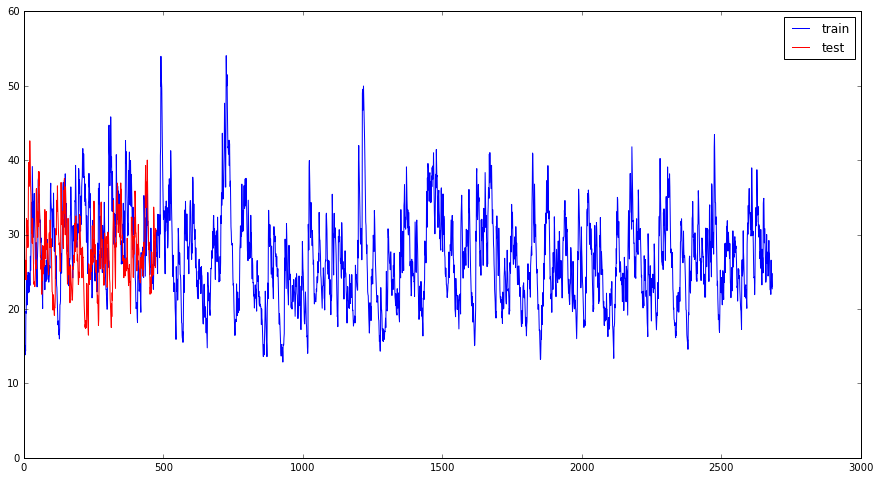

In [21]:
plt.figure(figsize=(15,8))
plt.plot(train_error_smooth, 'b',label = "train");
plt.plot(test_error_smooth, 'r',label = "test");
plt.legend();
plt.show();

##4 Layer Fully Connected Forward Feeding Network

In [22]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    (h, w) = shape
    # Glorot normalization - last factor depends on non-linearity
    # 0.25 for sigmoid and 0.1 for softmax, 1.0 for tanh or Relu
    normalizer = 2.0 * sqrt(6) / sqrt(h + w) * 1.0
    #return theano.shared(floatX(np.random.randn(*shape) * 0.01))  
    #code for standard initialization
    #code for using Glorot initialization
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))

def rectify(X):
    #return T.maximum(X, 0.)
    return T.maximum(X, 0.01*(T.exp(X)-1))  #exponential linear rectifer
    #return T.maximum(X, 0.01*X)  #leaky rectifier


def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def adaGrad(cost, params, eta=0.1, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        sumGSq = theano.shared(p.get_value() * 0.)
        sumGSq_new = sumGSq + g ** 2
        gradient_scaling = T.sqrt(sumGSq_new + epsilon)
        g = g / gradient_scaling
        updates.append((sumGSq, sumGSq_new))
        updates.append((p, p - eta * g))
    return updates

def adaDelta(cost, params, eta=1.0, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        #calc g-squared
        gSq = theano.shared(p.get_value() * 0.)
        dwSq = theano.shared(p.get_value() * 0.)

        #exp smoothed g squared
        gSqNew = rho * gSq + (1 - rho) * g * g

        #calc dx-squared
        dw = eta * T.sqrt(dwSq + epsilon) * g / T.sqrt(gSq + epsilon)
        dwSqNew = rho * dwSq + (1 - rho) * dw * dw

        updates.append((dwSq, dwSqNew))
        updates.append((gSq, gSqNew))
        updates.append((p, p - dw))
    return updates

def model(X, w_h,w_h2,w_h3, w_o, b_h, b_h2,b_h3):
    h = rectify(T.dot(X, w_h) + b_h)

    h2 = rectify(T.dot(h, w_h2) + b_h2)

    h3 = rectify(T.dot(h2, w_h3) + b_h3)
    
    y_x = rectify(T.dot(h3, w_o))
    
    return y_x

In [23]:
X = T.fmatrix()
Y = T.fscalar()

e = 1.0
nInputs = Xtrain.shape[1]
nOutputs = 1

# create bias terms
b_h = theano.shared(floatX(np.zeros((100))))
b_h2 = theano.shared(floatX(np.zeros((500))))
b_h3 = theano.shared(floatX(np.zeros((100))))

w_h = init_weights((nInputs, 100)) # 1st hidden layer
w_h2 = init_weights((100, 500)) # 2nd hidden layer
w_h3 = init_weights((500, 100)) # 3rd hidden layer
w_o = init_weights((100, nOutputs))   # output layer

In [24]:
y = model(X, w_h,w_h2,w_h3, w_o, b_h, b_h2,b_h3)

cost = (( y - Y)**2).mean(axis=0).sum()

params = [w_h,w_h2,w_h3, w_o, b_h, b_h2,b_h3]

#updates = RMSprop(cost, params, lr=0.0001)
updates = adaGrad(cost, params, eta=0.001, epsilon=0.01) 
#updates = adaDelta(cost, params, eta=0.1, rho=0.9, epsilon=0.1)
#updates = nesterovAG(cost, params, c=1.0)



train = theano.function(inputs=[X, Y], 
                        outputs=cost, 
                        updates=updates, 
                        allow_input_downcast=True)

predict = theano.function(inputs=[X,Y], 
                          outputs=cost, 
                          allow_input_downcast=True)

###Train Model

In [38]:
train_error = []
train_error_smooth = []
for i in xrange(0,len(Xtrain)):
    u = Xtrain[i].reshape((1,nInputs))
    t = ytrain[i]
    c = train(u, t)
    e = 0.1*np.sqrt(c) + 0.9*e
    train_error.append(np.sqrt(c))
    train_error_smooth.append(e)

###Test Model

In [39]:
test_error = []
test_error_smooth = []

for j in xrange(0,len(Xtest)):
    u = Xtest[j].reshape((1,nInputs))
    t = Ytest[j]
    c = predict(u,t)
    e = 0.1*np.sqrt(c) + 0.9*e
    test_error.append(np.sqrt(c))
    test_error_smooth.append(e)

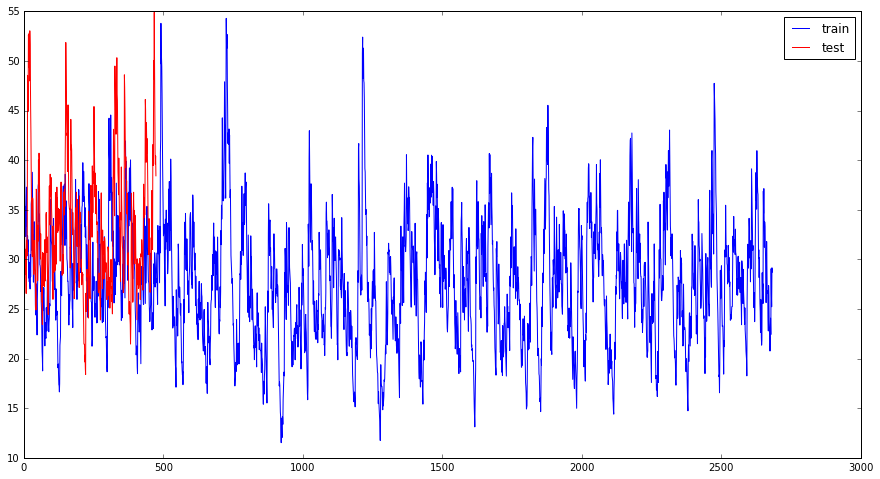

In [40]:
plt.figure(figsize=(15,8));
plt.plot(train_error_smooth,'b', label="train");
plt.plot(test_error_smooth,'r',label="test");
plt.legend();
plt.show();

###Score Model

In [41]:
SEP_FC_train = get_Strong_Error_Percentage(train_error)

In [42]:
SEP_FC_test = get_Strong_Error_Percentage(test_error)

In [43]:
print "Train Error {:.4}".format(SEP_FC_train)
print "Test Error  {:.4}".format(SEP_FC_test)

Train Error 0.3444
Test Error  0.4051


##Comparision 

In his paper, Bengio reports Strong Error Percentage results from 3 neuro nets. The best performing models had a score of 1.68 while my models had Strong Error Percentages around 0.35, such a difference is suspect.

I calculated the Strong Error Percentage by using the fact that the cost is the squared difference between the predicted number of sunspots and the true number of subspots. 

$$ sqrt(cost) = distance(y, \hat{y}) =  |y - \hat{y}|$$

In his paper, Bengio states that if the distance was less and 30, then that was considered an accuate prediction, otherwise the prediction was a miss. This is how I coded the Strong Error Percentage metric.

$$ |y - \hat{y}| > 30 ~\rightarrow~ miss$$
$$ |y - \hat{y}| < 30 ~\rightarrow~ hit$$

Bengio states that he used 1666 data points and split them into 85% train and 15% test. I about double the number of data points, so should encorage better results.